# Introduction to machine learning

*Maxime Sangnier*

Fall, 2022

## Practical session 4: Gaussian mixture models and k-means

# Table of contents
1. [Gaussian mixture models](#part1)
1. [k-means](#part2)


In [1]:
from mllab import *
from sklearn import datasets as data


Packages:
	nympy as np
	matplotlib.pyplot as plt
	seaborn as sns

Functions:
	plotXY
	plot_frontiere
	map_regions
	covariance
	plot_cov
	sample_gmm
	scatter
	plot_level_set
	gaussian_sample



# Gaussian mixture models <a id="part1"></a>
>Draw a sample of size 200 from a Gaussian mixture model with parameters
$$
    \begin{cases}
        \pi_1 &= 0.33\\
        \mu_1 &= (0, 0),
    \end{cases}
$$
$$
    \begin{cases}
        \pi_2 &= 0.33\\
        \mu_2 &= (5, 0),
    \end{cases}
$$
$$
    \begin{cases}
        \pi_3 &= 0.34\\
        \mu_3 &= (2, -5),
    \end{cases}
$$
and with same identity covariance matrix.
Plot the "contours" of the three clusters and their centers.

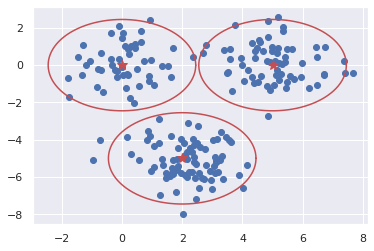

In [2]:
# Answer
(weights, means, covariances) = ([0.33, 0.33, 0.34],
                                 [[0, 0], [5, 0], [2, -5]],
                                 [(1, 1, 0), (1, 1, 0), (1, 1, 0)])

X = sample_gm(weights, means, [covariance(*c) for c in covariances], size=200)

plt.scatter(X[:,0], X[:, 1])
for mean, cov_param in zip(means, covariances):
    plt.plot(mean[0], mean[1], 'r*', markersize=10)
    plot_cov(covariance(*cov_param), mean)

>Complete the following emplementation of soft k-means.

In [3]:
# Answer
class SoftKMeans(object):
    def __init__(self, n_components=1, n_iter=100):
        self.n_components = n_components
        self.n_iter = n_iter
    
    def fit(self, X):
        # Initialization
        n_components = self.n_components
        # List of initial weights, means and covariances
        # (initial means can be taken at random among the trainin points)
        # To do
        weights = [1/n_components] * n_components  # List of initial weights
        #means = [np.random.rand(X.shape[1]) * (X.max(axis=0)-X.min(axis=0)) + X.min(axis=0)
        #        for k in range(n_components)]
        means = np.random.permutation(X)[:n_components]  # List of initial means
        covariances = [np.eye(X.shape[1]) for k in range(n_components)]  # List of initial covariance matrices
        # End to do
        
        # Multivariate Gaussian pdf
        def pdf(X, mean, cov):
            invcov = np.linalg.inv(cov + 1e-6*np.eye(cov.shape[0]))
            r = np.exp(-0.5*np.diag((X-mean).dot(invcov.dot((X-mean).T))))
            r *= np.sqrt(np.linalg.det(invcov/(2*np.pi)))
            return r
            
        # Loop
        log_likelihood = []  # Marginal log-likelihood at each iteration
        em_log_likelihood = []  # Average joint log-likelihood at each iteration
        # Compute the matrix of joint density values (size #components x #points)
        # and update weights, means and covariances
        for it in range(self.n_iter):
            # Parameter update
            # To do
            # Matrix of joint density values (size #components x #points)
            joint_density = np.array([w * pdf(X, m, c)
                                      for w, m, c in zip(weights, means, covariances)])
            p = joint_density / joint_density.sum(axis=0)  # Conditional probabilities
            weights = p.mean(axis=1)  # Prior probabilities
            means = p.dot(X) / p.sum(axis=1)[:, np.newaxis]  # Means
            covariances = [(X-m).T.dot(np.diag(w).dot(X-m)) / w.sum()
                           for w, m in zip(p, means)]  # List of covariance matrices
            # End to do
            
            # Log-likelihoods computation
            # To do
            log_likelihood.append(np.log(joint_density.sum(axis=0)).sum())
            em_log_likelihood.append(np.sum(p * np.log(joint_density)))
            # End to do
        self.weights_ = np.array(weights)
        self.means_ = np.array(means)
        self.covariances_ = np.array(covariances)
        self.log_likelihood_ = log_likelihood
        self.em_log_likelihood_ = em_log_likelihood


>Fit a soft k-means with 3 components and 20 iterations on the data.
Print the prior probabilities.
Plot the training dataset along with the means and the covariance matrices estimated.

>Are the results consistent with the way the data has been generated?

weights [0.33316742 0.42006672 0.24676587]


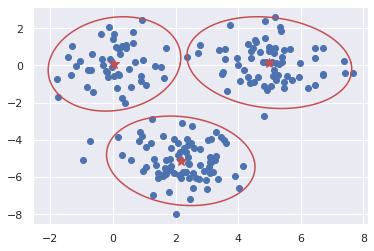

In [4]:
# Answer
skm = SoftKMeans(n_components=3, n_iter=20)
skm.fit(X)
print("weights", skm.weights_)

plt.scatter(X[:, 0], X[:, 1])
for (mean, cov) in zip(skm.means_, skm.covariances_):
    plt.plot(mean[0], mean[1], 'r*', markersize=10)
    plot_cov(cov, mean)

>Plot the two log-likelihoods versus the number of iterations.
Is the marginal log-likelihood non-decreasing?
Is it bounded from below by the average joint log-likelihood?

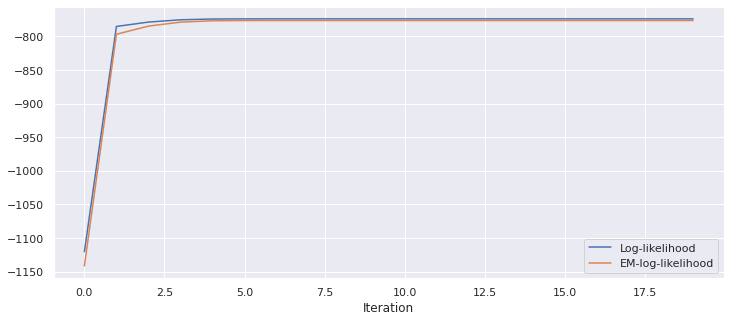

In [5]:
# Answer
plt.figure(figsize=(12, 5))
plt.plot(skm.log_likelihood_, label="Log-likelihood")
plt.plot(skm.em_log_likelihood_, label="EM-log-likelihood")
plt.xlabel("Iteration")
plt.legend(loc="best");

>With the help of the [Gaussian mixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture), estimate the parameters of a 3-componenents Gaussian mixture.
Print the prior probabilities and the maximal value of log-likelihood.
Plot the training dataset along with the means and the covariance matrices estimated.

>Are the results consistent with the your own implementation?

weights (own) [0.33316742 0.42006672 0.24676587]
weights (sklearn) [0.24731887 0.42007642 0.33260471]
best EM log-likelihood (own) -3.869380022453523
best EM log-likelihood (sklearn) -3.869474992699029


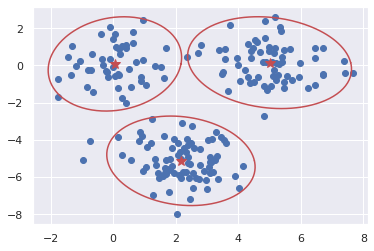

In [6]:
# Answer
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3)
gmm.fit(X)

print("weights (own)", skm.weights_)
print("weights (sklearn)", gmm.weights_)

print("best EM log-likelihood (own)", skm.log_likelihood_[-1] / X.shape[0])
print("best EM log-likelihood (sklearn)", gmm.lower_bound_)

plt.scatter(X[:, 0], X[:, 1])
for (mean, cov) in zip(gmm.means_, gmm.covariances_):
    plt.plot(mean[0], mean[1], 'r*', markersize=10)
    plot_cov(cov, mean)

>Repeat the estimation several (let us say 9) times.
Are the results stable?

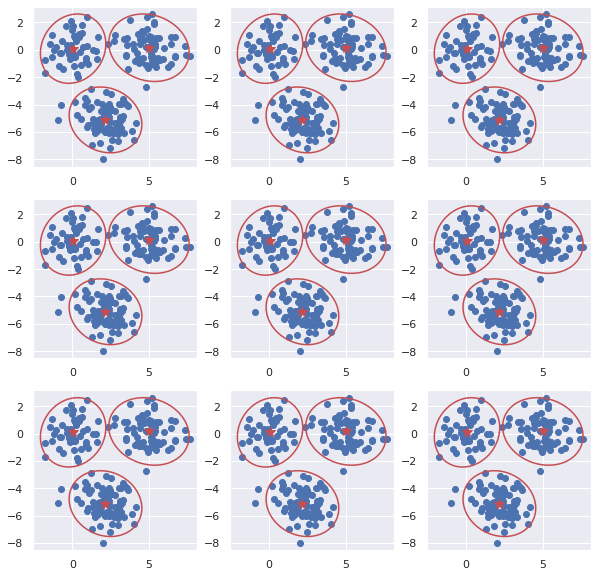

In [7]:
# Answer
gmm = GaussianMixture(n_components=3)

plt.figure(figsize=(10, 10))
for it in range(9):
    gmm.fit(X)
    
    plt.subplot(3, 3, it+1)
    plt.scatter(X[:, 0], X[:, 1])
    for (mean, cov) in zip(gmm.means_, gmm.covariances_):
        plt.plot(mean[0], mean[1], 'r*', markersize=10)
        plot_cov(cov, mean)

>What if initial parameters are set at random (look for the suitable parameter of [Gaussian mixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture))?

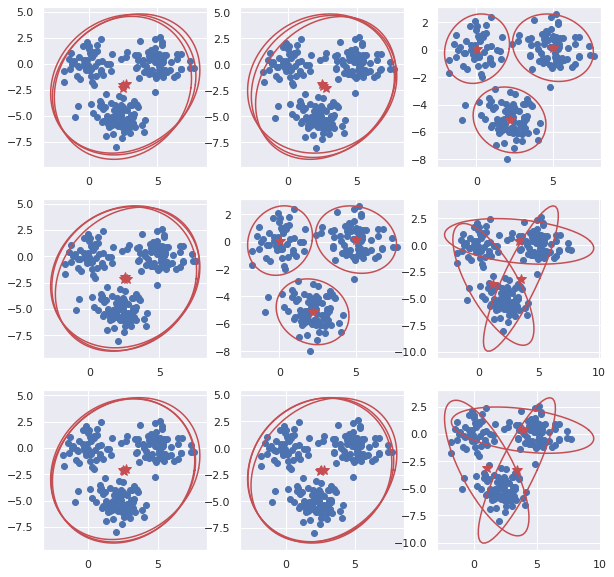

In [8]:
# Answer
gmm = GaussianMixture(n_components=3, init_params="random")
plt.figure(figsize=(10, 10))
for it in range(9):
    gmm.fit(X)
    
    plt.subplot(3, 3, it+1)
    plt.scatter(X[:, 0], X[:, 1])
    for (mean, cov) in zip(gmm.means_, gmm.covariances_):
        plt.plot(mean[0], mean[1], 'r*', markersize=10)
        plot_cov(cov, mean)

>Complete the following script in order to:
1. sample from a Gaussian mixture;
1. fit a  [Gaussian mixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) model;
1. plot the training set, the means and the variance "contours".

>Analyze the results (there should be "unexpected" results).

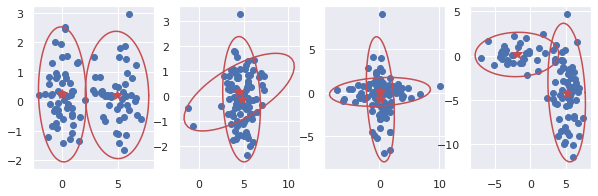

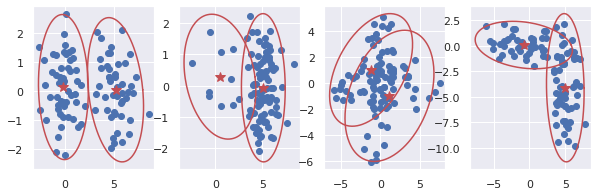

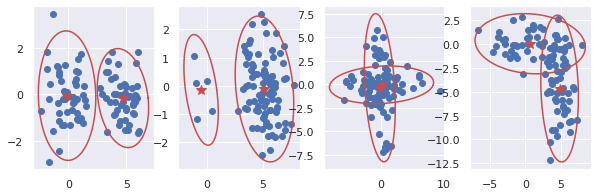

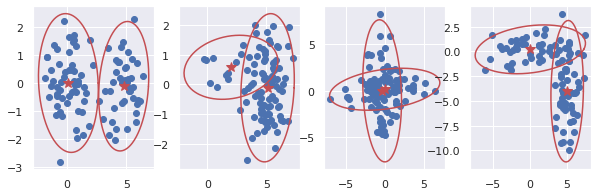

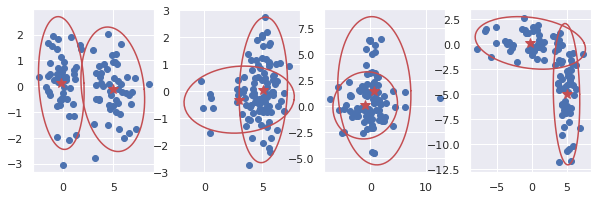

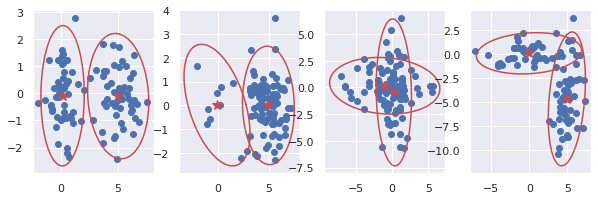

In [9]:
# Answer
gmm = GaussianMixture(n_components=2)

for it in range(6):
    plt.figure(figsize=(10, 3))
    for it, (weights, means, covariances) in enumerate([
        ([0.5, 0.5], [[0, 0], [5, 0]], [(1, 1, 0), (1, 1, 0)]),
        ([0.05, 0.95], [[0, 0], [5, 0]], [(1, 1, 0), (1, 1, 0)]),
        ([0.5, 0.5], [[0, 0], [0, 0]], [(10, 1, 0), (1, 10, 0)]),
        ([0.5, 0.5], [[0, 0], [5, -5]], [(10, 1, 0), (1, 10, 0)])]):
        X = sample_gm(weights, means, [covariance(*c) for c in covariances], size=100)
        # To do
        gmm.fit(X)
        plt.subplot(1, 4, it+1)
        plt.scatter(X[:, 0], X[:, 1])
        for (mean, cov) in zip(gmm.means_, gmm.covariances_):
            plt.plot(mean[0], mean[1], 'r*', markersize=10)
            plot_cov(cov, mean)
        # End to do

# k-means <a id="part2"></a>


>Given the followin data, fit a [Gaussian mixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture).
Display the cluster centers along with the partitioning (use the function `map_regions`).

In [10]:
(weights, means, covariances) = ([0.3, 0.2, 0.5], [[-5, -1], [5, 0], [2, -5]],
                                 [(1, 5, np.pi/3), (1, 5, np.pi/3), (5, 1, np.pi/3)])
X = sample_gm(weights, means, [covariance(*c) for c in covariances], size=200)

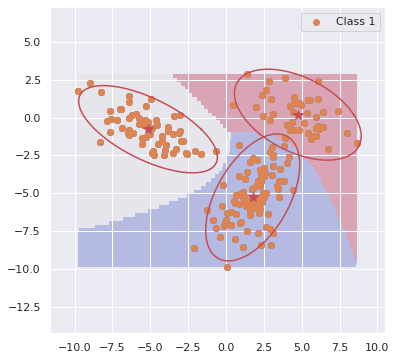

In [11]:
# Answer
gmm = GaussianMixture(n_components=3)
gmm.fit(X)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1])
for (mean, cov) in zip(gmm.means_, gmm.covariances_):
    plt.plot(mean[0], mean[1], 'r*', markersize=10)
    plot_cov(cov, mean)
map_regions(gmm, data=X)

>Do the same with [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).
What is the difference?

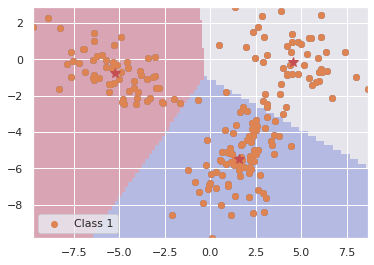

In [12]:
# Answer
from sklearn.cluster import KMeans

clt = KMeans(n_clusters=3)
clt.fit(X)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1])
plt.plot(clt.cluster_centers_[:, 0], clt.cluster_centers_[:, 1], 'r*', markersize=10)
map_regions(clt, data=X)
plt.axis("image");

>Given the following dataset, perform several [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering with a random initialization (original version of k-means).
What do you observe?

In [13]:
(weights, means, covariances) = ([0.05, 0.2, 0.75], [[-5, -1], [5, 0], [2, -5]],
                                 [(1, 5, np.pi/3), (1, 5, np.pi/3), (5, 1, np.pi/3)])
X = sample_gm(weights, means, [covariance(*c) for c in covariances], size=100)

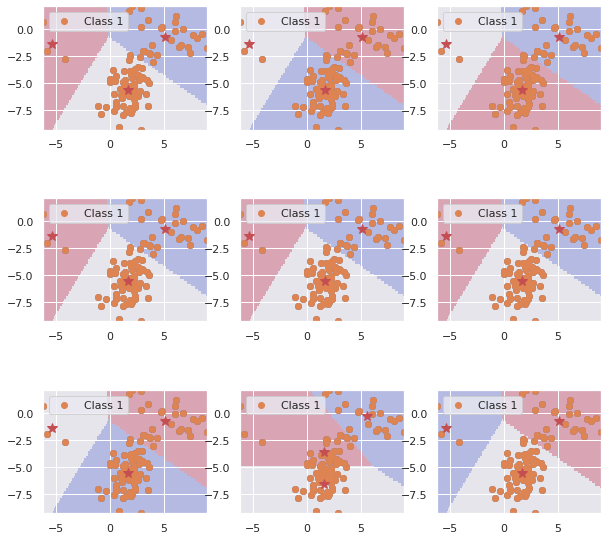

In [14]:
# Answer
clt = KMeans(n_clusters=3, init="random")

plt.figure(figsize=(10, 10))
for it in range(9):
    clt.fit(X)

    plt.subplot(3, 3, it+1)
#    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1])
    plt.plot(clt.cluster_centers_[:, 0], clt.cluster_centers_[:, 1], 'r*', markersize=10)
    map_regions(clt, data=X)
    plt.axis("image");

>Here, we aim at analyzing [Gaussian mixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) and [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) for non-convex clusters.
For this purpose:
1. generate [moons](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) (then [circles](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles)) with noise set to $0.1$;
1. plot the two classes with `plotXY`;
1. display the two-cluster partitioning (`map_regions`) obtained with [Gaussian mixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) and [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

>What do you observe?

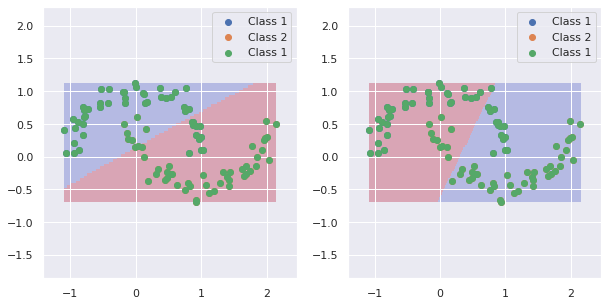

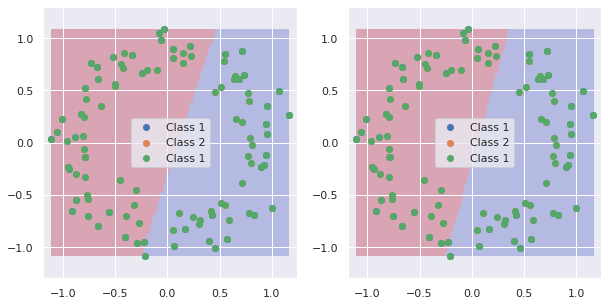

In [15]:
# Answer
from sklearn.datasets import make_moons, make_circles

for make_data in [make_moons, make_circles]:
    X, y = make_data(noise=0.1)

    plt.figure(figsize=(10, 5))
    for it, clt in enumerate([GaussianMixture(n_components=2), KMeans(n_clusters=2)]):
        clt.fit(X)

        plt.subplot(1, 2, it+1)
        plotXY(X, y)
        map_regions(clt, data=X)